In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

In [32]:
# folder_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordNonword/all-token_words3"
folder_path = "/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordNonword/two-token_words2"
dataset_paths = glob.glob(os.path.join(folder_path, "*.csv"))

# Define colors for each model
model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}

# Define colors for each language
language_colors = {
    "English": "#1f77b4",
    "Korean": "#ff7f0e",
    "German": "#2ca02c"
}

# Define line styles for each model
model_styles = {
    "Babel-9B-Chat": "-",
    "gemma-3-12b-it": "--",
    "Llama-2-7b-chat-hf": ":"
}

languague_styles = {
    "English": "-",
    "Korean": "--",
    "German": ":"
}

# KNN

## find best n_neighbors

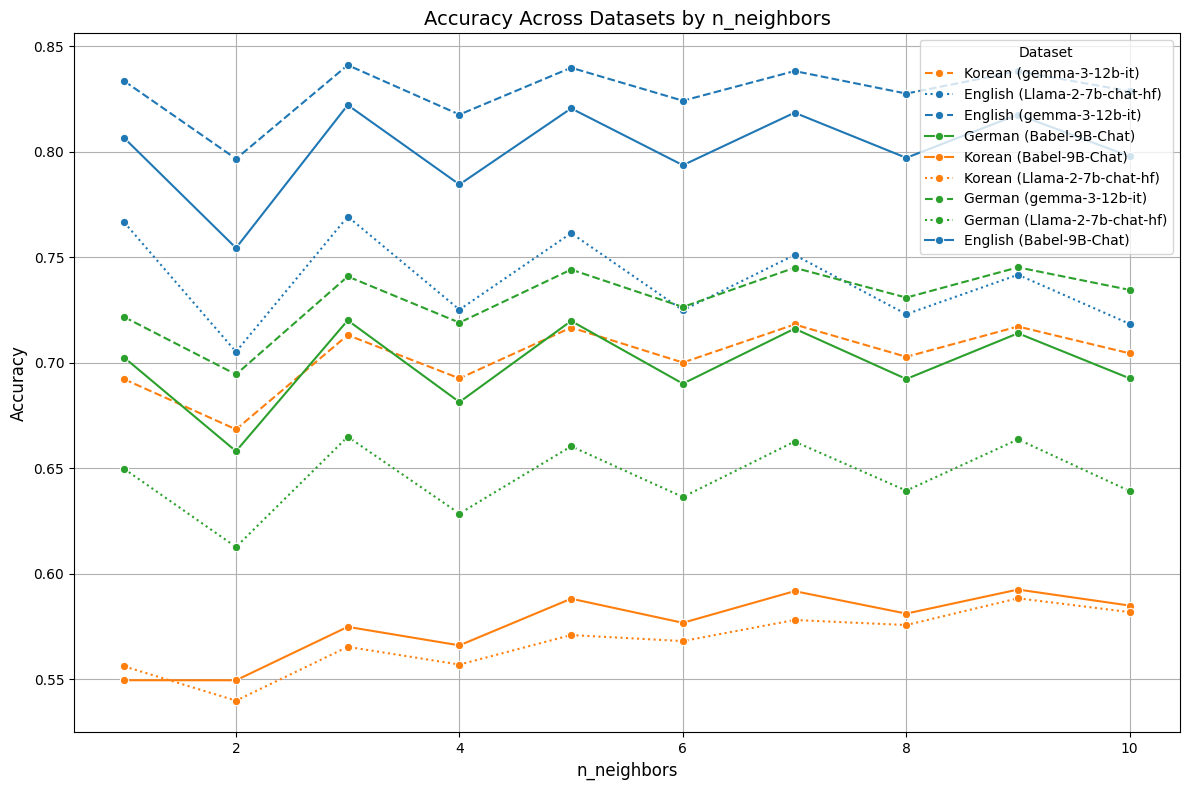

In [33]:
def plot_accuracy_across_datasets(dataset_paths):
    """
    Plots accuracy for each dataset as a line, grouped by language with the same color.

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    """
    plt.figure(figsize=(12, 8))

    for dataset_path in dataset_paths:
        # Extract language and tokenizer from the filename
        filename = os.path.basename(dataset_path)
        language_match = re.search(r'_(English|Korean|German)[-_]', filename)
        language = language_match.group(1) if language_match else "Unknown"
        tokenizer_match = re.search(r'knn_eval_results_([^_]+)_', filename)
        tokenizer = tokenizer_match.group(1) if tokenizer_match else "Unknown"

        # Load the dataset
        df = pd.read_csv(dataset_path)
        df = df[df["n_neighbors"] <= 10]

        # Group by n_neighbors and calculate the mean accuracy
        mean_accuracy = df.groupby("n_neighbors")["Accuracy"].mean().reset_index()

        # Plot the line for this dataset
        sns.lineplot(
            data=mean_accuracy,
            x="n_neighbors",
            y="Accuracy",
            label=f"{language} ({tokenizer})",
            color=language_colors.get(language, "black"), 
            # color=model_colors.get(tokenizer, "black"), 
            linestyle=model_styles.get(tokenizer, "dashdot"),
            # linestyle=language_styles.get(language, "-"),
            marker="o"
        )

    # Add labels, title, and legend
    plt.xlabel("n_neighbors", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Accuracy Across Datasets by n_neighbors", fontsize=14)
    plt.legend(title="Dataset", fontsize=10, loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_accuracy_across_datasets(dataset_paths)

In [38]:
import pandas as pd
import os

def find_best_n_neighbors(dataset_paths):
    """
    Finds the best n_neighbors value across multiple datasets based on average accuracy.

    Args:
    - dataset_paths (list): List of file paths to the datasets.

    Returns:
    - int: The best n_neighbors value.
    """
    all_results = []

    for dataset_path in dataset_paths:
        # Load the dataset
        df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))
        df = df[df["n_neighbors"] <= 10]
        # Group by n_neighbors and calculate the mean accuracy
        mean_accuracy = df.groupby("n_neighbors")["Accuracy"].mean().reset_index()
        mean_accuracy["dataset"] = os.path.basename(dataset_path)  # Add dataset name for reference
        all_results.append(mean_accuracy)

    # Combine results from all datasets
    combined_results = pd.concat(all_results, ignore_index=True)

    # Calculate the overall average accuracy for each n_neighbors value
    overall_mean_accuracy = combined_results.groupby("n_neighbors")["Accuracy"].mean()

    # Find the n_neighbors value with the highest average accuracy
    best_n_neighbors = overall_mean_accuracy.idxmax()
    best_accuracy = overall_mean_accuracy.max()

    print(f"Best n_neighbors: {best_n_neighbors} with average accuracy: {best_accuracy:.4f}")
    return best_n_neighbors

best_n_neighbors = find_best_n_neighbors(dataset_paths)

Best n_neighbors: 5 with average accuracy: 0.7135


## plot knn results

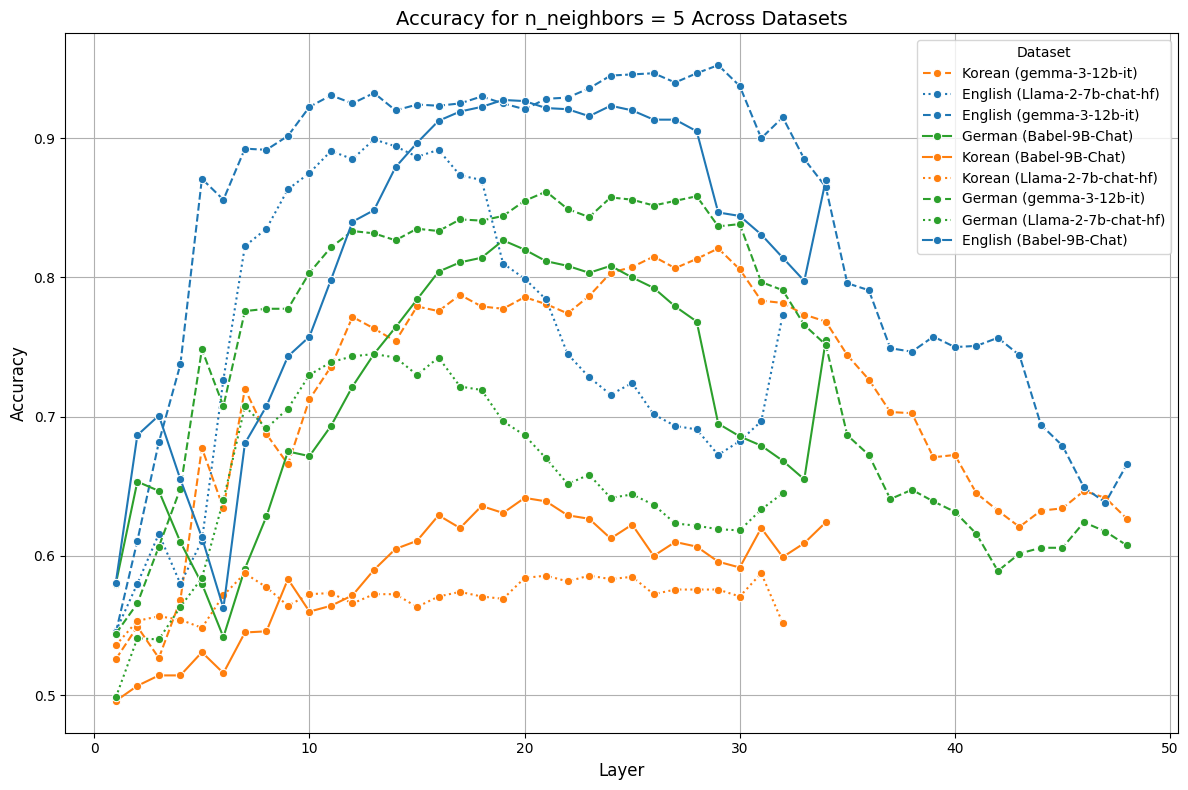

In [39]:
def plot_n_neighbors_5_accuracy(dataset_paths, language_colors, model_styles):
    """
    Plots accuracy for n_neighbors = 5 for each dataset, grouped by language (color) and model (line style).

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    - model_styles (dict): Dictionary mapping models to line styles.
    """
    plt.figure(figsize=(12, 8))

    for dataset_path in dataset_paths:
        # Extract language and tokenizer from the filename
        filename = os.path.basename(dataset_path)
        language = filename.split("_")[4].split("-")[0]  # Extract language (e.g., "English", "Korean", "German")
        model = filename.split("_")[3]  # Extract tokenizer (e.g., "Babel-9B-Chat")

        # Load the dataset
        df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))

        # Filter for n_neighbors = 5
        filtered_df = df[df["n_neighbors"] == best_n_neighbors]

        # Plot the line for this dataset
        sns.lineplot(
            data=filtered_df,
            x="Layer",
            y="Accuracy",
            label=f"{language} ({model})",
            # label=filename,
            color=language_colors.get(language, "black"),  # Use the color for the language
            linestyle=model_styles.get(model, "dashdot"),  # Use the line style for the model
            marker="o"
        )

    # Add labels, title, and legend
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title(f"Accuracy for n_neighbors = {best_n_neighbors} Across Datasets", fontsize=14)
    plt.legend(title="Dataset", fontsize=10, loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_n_neighbors_5_accuracy(dataset_paths, language_colors, model_styles)

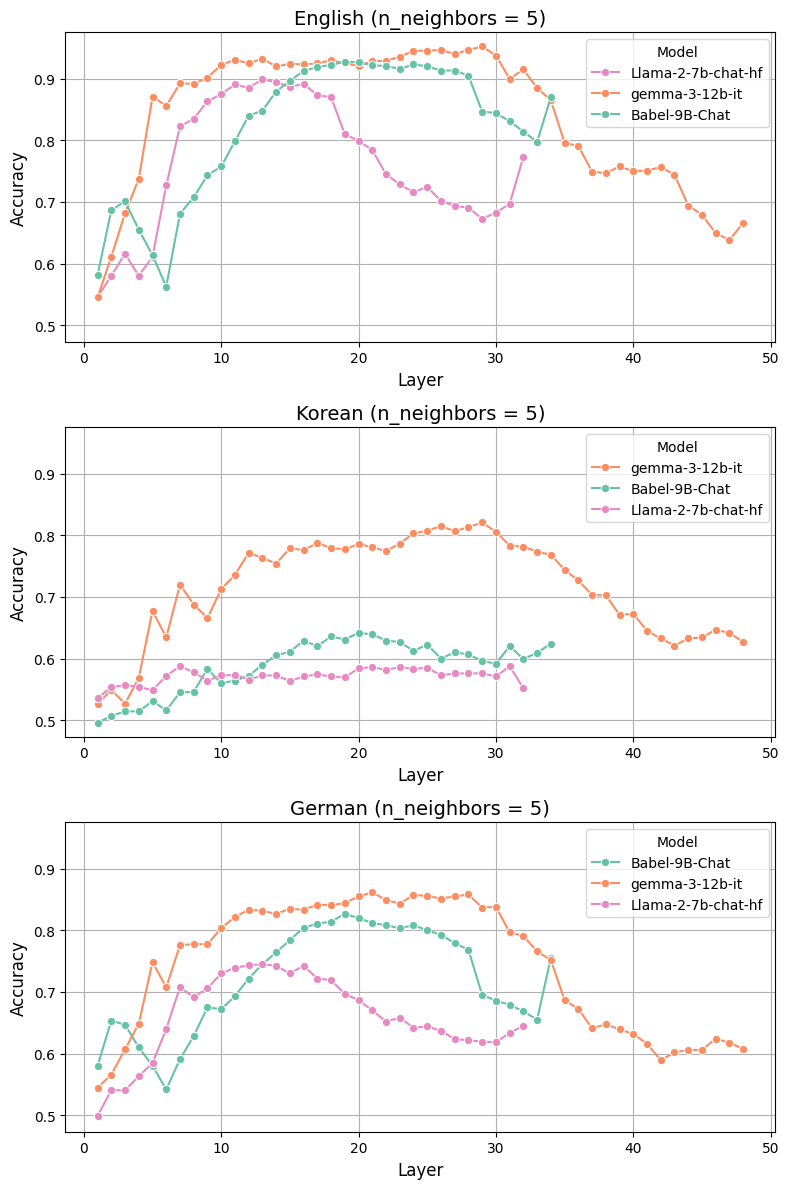

In [ ]:
def plot_n_neighbors_5_accuracy_by_language(dataset_paths, language_colors, model_styles, metric="Accuracy"):
    """
    Creates separate subplots for each language, showing accuracy for n_neighbors = 5 for all models.

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    - model_styles (dict): Dictionary mapping models to line styles.
    """
    # Group datasets by language
    language_datasets = {"English": [], "Korean": [], "German": []}
    for dataset_path in dataset_paths:
        filename = os.path.basename(dataset_path)
        language = filename.split("_")[4].split("-")[0]  # Extract language
        language_datasets[language].append(dataset_path)

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)
    for ax, (language, paths) in zip(axes, language_datasets.items()):
        max_y = 0
        for dataset_path in paths:
            # Extract model from the filename
            filename = os.path.basename(dataset_path)
            model = filename.split("_")[3]  # Extract tokenizer (e.g., "Babel-9B-Chat")


            # Load the dataset
            df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))

            # Filter for n_neighbors = 5
            filtered_df = df[df["n_neighbors"] == best_n_neighbors]

            # Plot the line for this dataset
            sns.lineplot(
                data=filtered_df,
                x="Layer",
                y=f"{metric}",
                label=model,
                color=model_colors.get(model, "black"),
                # color=language_colors.get(language, "black"),  # Use the color for the language
                # linestyle=model_styles.get(model, "-"),  # Use the line style for the model
                marker="o",
                ax=ax
            )
            
            max_y = max(max_y, filtered_df[f"{metric}"].max())

        # Customize each subplot
        ax.set_title(f"{language} (n_neighbors = {best_n_neighbors})", fontsize=14)
        ax.set_xlabel("Layer", fontsize=12)
        ax.set_ylabel(f"{metric}", fontsize=12)
        ax.legend(title="Model", fontsize=10, loc="best")
        ax.grid(True)
        # ax.set_ylim(0, max_y + 0.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_n_neighbors_5_accuracy_by_language(dataset_paths, language_colors, model_styles)

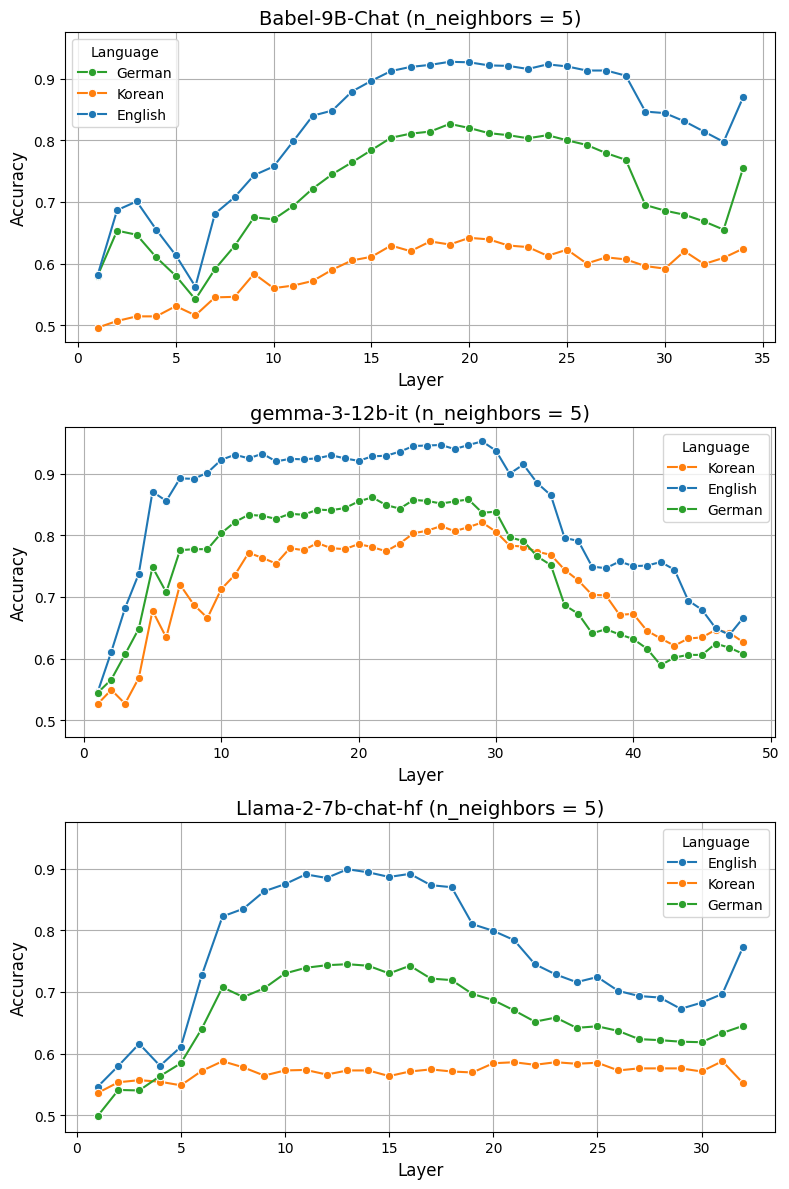

In [42]:
def plot_n_neighbors_5_accuracy_by_model(dataset_paths, model_colors, language_styles):
    """
    Creates separate subplots for each model, showing accuracy for n_neighbors = 5 for all languages.

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - model_colors (dict): Dictionary mapping models to colors.
    - language_styles (dict): Dictionary mapping languages to line styles.
    """
    # Group datasets by model
    model_datasets = {"Babel-9B-Chat": [], "gemma-3-12b-it": [], "Llama-2-7b-chat-hf": []}
    for dataset_path in dataset_paths:
        filename = os.path.basename(dataset_path)
        model = filename.split("_")[3]  # Extract model
        model_datasets[model].append(dataset_path)

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)
    for ax, (model, paths) in zip(axes, model_datasets.items()):
        max_y = 0
        for dataset_path in paths:
            # Extract language from the filename
            filename = os.path.basename(dataset_path)
            language = filename.split("_")[4].split("-")[0]  # Extract language

            # Load the dataset
            df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))

            # Filter for n_neighbors = 5
            filtered_df = df[df["n_neighbors"] == best_n_neighbors]

            # Plot the line for this dataset
            sns.lineplot(
                data=filtered_df,
                x="Layer",
                y="Accuracy",
                label=language,
                # color=model_colors.get(model, "black"),
                color=language_colors.get(language, "black"),  # Use the color for the language
                # linestyle=language_styles.get(language, "-"),
                marker="o",
                ax=ax
            )

            max_y = max(max_y, filtered_df["Accuracy"].max())

        # Customize each subplot
        ax.set_title(f"{model} (n_neighbors = {best_n_neighbors})", fontsize=14)
        ax.set_xlabel("Layer", fontsize=12)
        ax.set_ylabel("Accuracy", fontsize=12)
        ax.legend(title="Language", fontsize=10, loc="best")
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_n_neighbors_5_accuracy_by_model(dataset_paths, model_colors, languague_styles)

# MLP

English Babel-9B-Chat
Korean Babel-9B-Chat
German Babel-9B-Chat
English gemma-3-12b-it
Korean gemma-3-12b-it
German gemma-3-12b-it
English Llama-2-7b-chat-hf
Korean Llama-2-7b-chat-hf
German Llama-2-7b-chat-hf


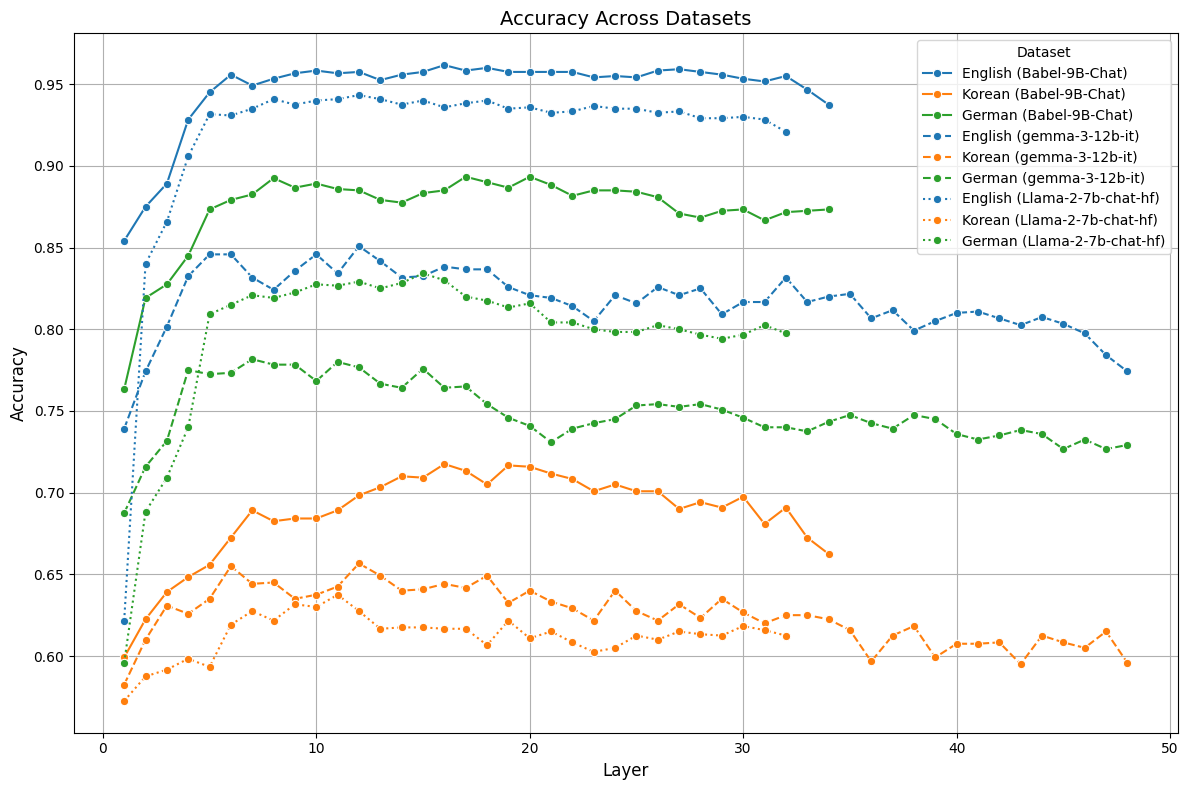

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

def plot_mlp_accuracy(dataset_paths, language_colors, model_styles):
    """
    Plots accuracy for n_neighbors = 5 for each dataset, grouped by language (color) and model (line style).

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    - model_styles (dict): Dictionary mapping models to line styles.
    """
    plt.figure(figsize=(12, 8))

    for dataset_path in dataset_paths:
        # Extract language and tokenizer from the filename
        filename = os.path.basename(dataset_path)
        # language = filename.split("_")[5].split("-")[0]  # Extract language (e.g., "English", "Korean", "German")
        language = None
        for lang in {"English", "Korean", "German"}:
            if lang in filename:
                language = lang
                break
        # match = re.search(r'\b(English|Korean|German)\b', filename)
        # language = match.group(1) if match else None

        model = filename.split("_")[4]  # Extract tokenizer (e.g., "Babel-9B-Chat")
        # model = filename
        print(language, model)
        # Load the dataset
        df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))

        # Plot the line for this dataset
        sns.lineplot(
            data=df,
            x="Layer",
            y="Accuracy",
            label=f"{language} ({model})",
            color=language_colors.get(language, "black"),  # Use the color for the language
            linestyle=model_styles.get(model, "dashdot"),  # Use the line style for the model
            marker="o"
        )

    # Add labels, title, and legend
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Accuracy Across Datasets", fontsize=14)
    plt.legend(title="Dataset", fontsize=10, loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mlp_accuracy(dataset_paths, language_colors, model_styles)

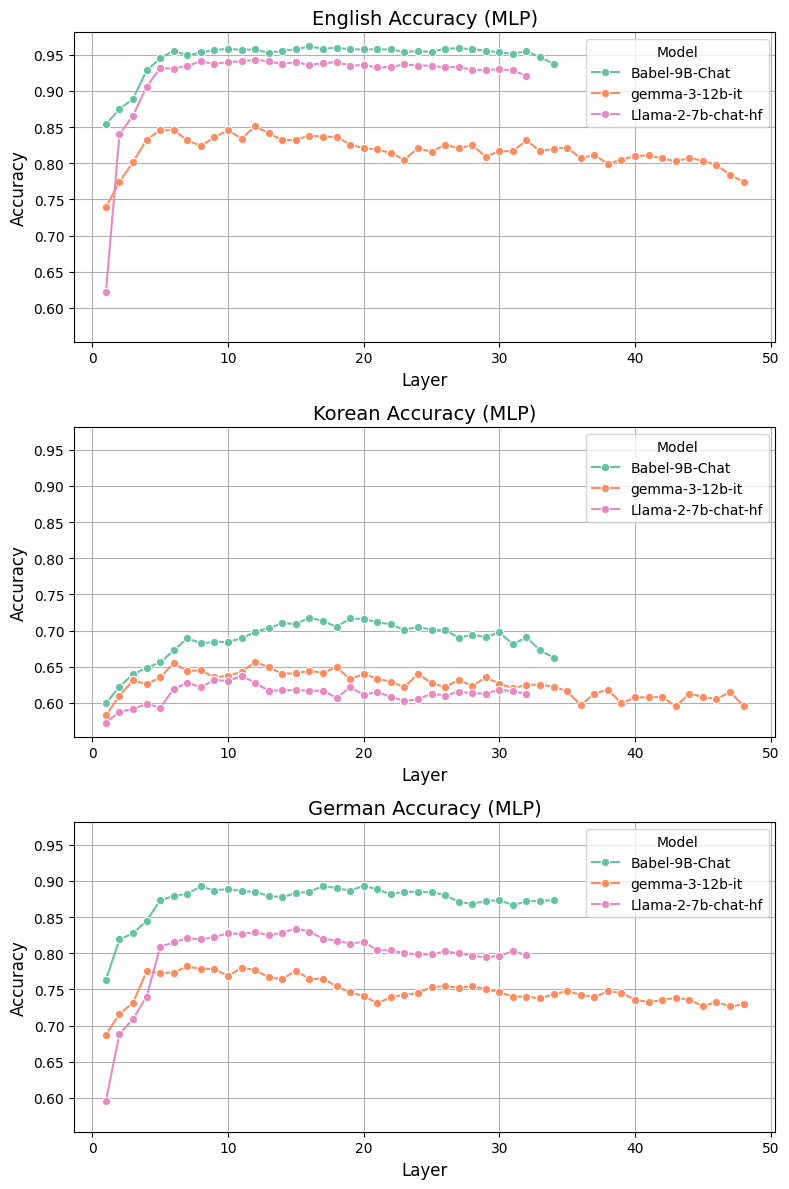

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_mlp_accuracy_by_language(dataset_paths, language_colors, model_styles, metric="Accuracy"):
    """
    Creates separate subplots for each language, showing accuracy for n_neighbors = 5 for all models.

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    - model_styles (dict): Dictionary mapping models to line styles.
    """
    # Group datasets by language
    language_datasets = {"English": [], "Korean": [], "German": []}
    for dataset_path in dataset_paths:
        filename = os.path.basename(dataset_path)

        language = None
        for lang in {"English", "Korean", "German"}:
            if lang in filename:
                language = lang
                break
        language_datasets[language].append(dataset_path)

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)
    for ax, (language, paths) in zip(axes, language_datasets.items()):
        max_y = 0
        for dataset_path in paths:
            # Extract model from the filename
            filename = os.path.basename(dataset_path)
            # model = filename.split("_")[3]  # Extract tokenizer (e.g., "Babel-9B-Chat")
            model = filename.split("_")[4]  # Extract tokenizer (e.g., "Babel-9B-Chat")

            # Load the dataset
            df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))
            
            # Plot the line for this dataset
            sns.lineplot(
                data=df,
                x="Layer",
                y=f"{metric}",
                label=model,
                color=model_colors.get(model, "black"),
                # color=language_colors.get(language, "black"),  # Use the color for the language
                # linestyle=model_styles.get(model, "-"),  # Use the line style for the model
                marker="o",
                ax=ax
            )
            
            max_y = max(max_y, df[f"{metric}"].max())

        # Customize each subplot
        ax.set_title(f"{language} {metric} (MLP)", fontsize=14)
        ax.set_xlabel("Layer", fontsize=12)
        ax.set_ylabel(f"{metric}", fontsize=12)
        ax.legend(title="Model", fontsize=10, loc="best")
        ax.grid(True)
        # ax.set_ylim(0, max_y + 0.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_mlp_accuracy_by_language(dataset_paths, language_colors, model_styles)

Babel-9B-Chat
Babel-9B-Chat
Babel-9B-Chat
gemma-3-12b-it
gemma-3-12b-it
gemma-3-12b-it
Llama-2-7b-chat-hf
Llama-2-7b-chat-hf
Llama-2-7b-chat-hf


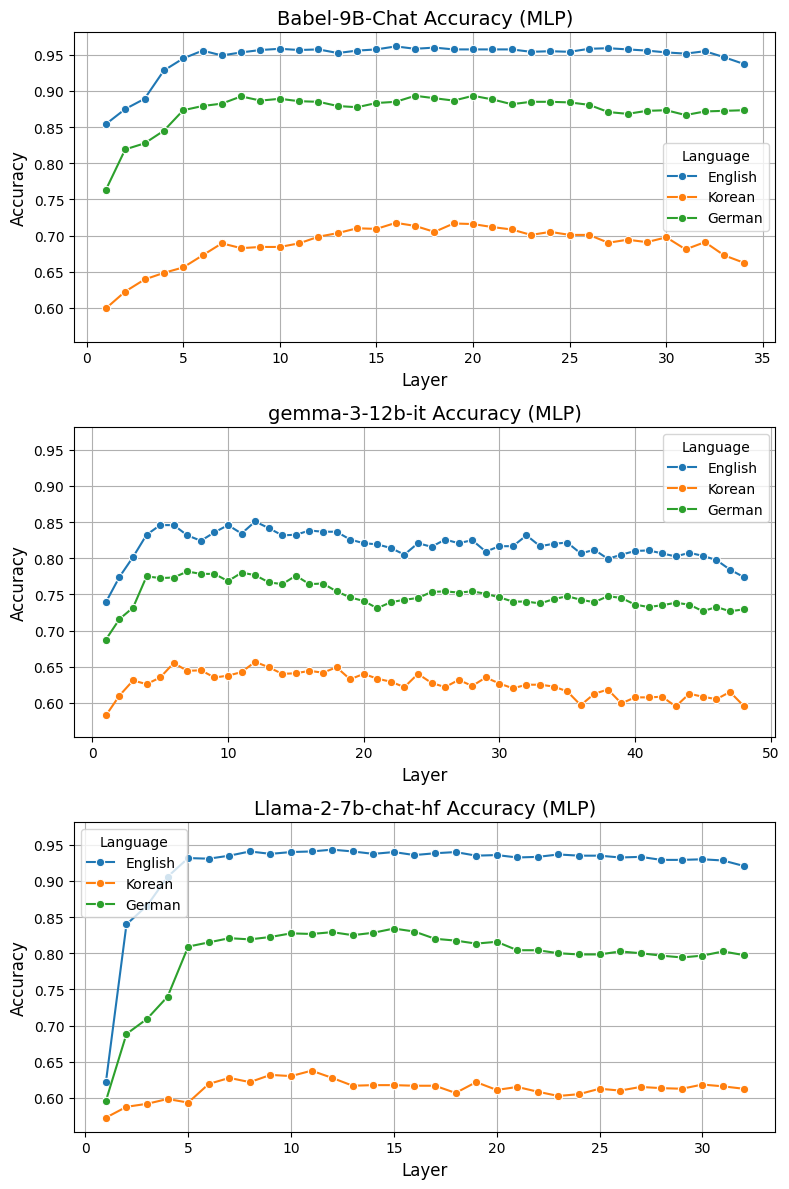

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_mlp_accuracy_by_model(dataset_paths, language_colors, model_styles, metric="Accuracy"):
    """
    Creates separate subplots for each language, showing accuracy for n_neighbors = 5 for all models.

    Args:
    - dataset_paths (list): List of file paths to the datasets.
    - language_colors (dict): Dictionary mapping languages to colors.
    - model_styles (dict): Dictionary mapping models to line styles.
    """
    # Group datasets by language
    model_datasets = {"Babel-9B-Chat": [], "gemma-3-12b-it": [], "Llama-2-7b-chat-hf": []}
    for dataset_path in dataset_paths:
        filename = os.path.basename(dataset_path)
        model = filename.split("_")[4]
        print(model)
        model_datasets[model].append(dataset_path)

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)
    for ax, (model, paths) in zip(axes, model_datasets.items()):
        max_y = 0
        for dataset_path in paths:
            # Extract model from the filename
            filename = os.path.basename(dataset_path)
            language = None
            for lang in {"English", "Korean", "German"}:
                if lang in filename:
                    language = lang
                    break

            # Load the dataset
            df = pd.read_csv(os.path.join("/home/hyujang/multilingual-inner-lexicon", dataset_path))
            # Plot the line for this dataset
            sns.lineplot(
                data=df,
                x="Layer",
                y=f"{metric}",
                label=language,
                # color=model_colors.get(model, "black"),
                color=language_colors.get(language, "black"),  # Use the color for the language
                # linestyle=model_styles.get(model, "-"),  # Use the line style for the model
                marker="o",
                ax=ax
            )
            
            max_y = max(max_y, df[f"{metric}"].max())

        # Customize each subplot
        ax.set_title(f"{model} {metric} (MLP)", fontsize=14)
        ax.set_xlabel("Layer", fontsize=12)
        ax.set_ylabel(f"{metric}", fontsize=12)
        ax.legend(title="Language", fontsize=10, loc="best")
        ax.grid(True)
        # ax.set_ylim(0, max_y + 0.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_mlp_accuracy_by_model(dataset_paths, language_colors, model_styles)